# CNN training

In [2]:
import os
import re
import copy
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pandas as pd

import PIL
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import sklearn

from __future__ import print_function
import keras
import keras.preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Tensorflow version 2.2.0


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functions

In [4]:
def fileToList(file_name):
    result_list = [] 
    fp = open(file_name)
    for row in fp:
        row = row.strip()
        row = row.replace("\"","")
        row = re.split('\t',row)
        #row = re.split(r'[;,\s]\s*', row)
        result_list.append(row)
    fp.close()  
    return result_list 

In [5]:
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))
    
    return model

In [6]:
def showImg(img_data):
    if type(img_data) is list:
        image = tf.keras.preprocessing.image.load_img(img_data)
        plt.imshow(image)
    if type(img_data) is np.ndarray:
        image = tf.keras.preprocessing.image.array_to_img(img_data)
        plt.imshow(image)

In [7]:
def resizeCropImg(img_file, target_width, target_height):
    image = tf.keras.preprocessing.image.load_img(img_file)
    width, height = image.size
    left   = width*0.13
    top    = height*0.13
    right  = width*0.87
    bottom = height*0.87
    image = image.crop((left, top, right, bottom))
    image = image.resize((target_width, target_height))
    return image

In [8]:
def loadImgs(cnv_list, img_width, img_height):
    cnv_np = np.zeros((len(cnv_list), img_width, img_height, 3))
    for index, each_cnv in enumerate(cnv_list):
        if index % 1000 == 1:
            time_stamp = datetime.datetime.now()
            time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
            print("[%s] Processing %d ..."%(time_str, index))
        cnv_img = resizeCropImg(each_cnv, img_width, img_height)
        cnv_np[index] = tf.keras.preprocessing.image.img_to_array(cnv_img)
    time_stamp = datetime.datetime.now()
    time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
    print("[%s] Done %d."%(time_str, index))
    return cnv_np

# Processing

In [9]:
img_width, img_height = 224, 224

In [10]:
## For rare deletions
true_file = '/home/rt2776/cnv_espresso/images_rare/true_del_image_info.list'
false_file = '/home/rt2776/cnv_espresso/images_rare/false_del_image_info.list'

In [11]:
# ## For rare duplications
# true_dup_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_dup.list'
# false_dup_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_dup.list'

In [12]:
# ## For splited rare deletions
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_del_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_del_splits.list'

In [13]:
# ## For splited rare duplications
# true_file = '/home/rt2776/cnv_espresso/images_rare/true_rare_dup_splits.list'
# false_file = '/home/rt2776/cnv_espresso/images_rare/false_rare_dup_splits.list'

### Loading cnv image file paths to list

In [14]:
true_cnv_df  = pd.read_csv(true_file,  header=0,sep='\t')
false_cnv_df = pd.read_csv(false_file, header=0,sep='\t')

In [15]:
true_images_path_list  = true_cnv_df['image_path']
false_images_path_list = false_cnv_df['image_path']

In [150]:
## For file with image path only:

# true_list = [each_file[0] for each_file in fileToList(true_file)]
# false_list = [each_file[0] for each_file in fileToList(false_file)]
# len(true_list), len(false_list)

### Loading images from list to numpy array

In [192]:
false_img_np = loadImgs(false_images_path_list, img_width, img_height)
false_img_np.shape

[2021.01.26-19:45:37] Processing 1 ...
[2021.01.26-19:47:15] Done 988.


(989, 224, 224, 3)

In [193]:
true_img_np = loadImgs(true_images_path_list, img_width, img_height)
true_img_np.shape

[2021.01.26-19:47:15] Processing 1 ...
[2021.01.26-19:48:57] Processing 1001 ...
[2021.01.26-19:50:37] Processing 2001 ...
[2021.01.26-19:52:23] Processing 3001 ...
[2021.01.26-19:54:09] Processing 4001 ...
[2021.01.26-19:55:55] Processing 5001 ...
[2021.01.26-19:56:14] Done 5179.


(5180, 224, 224, 3)

### Generage labels

In [197]:
true_label = [1 for i in range(0,len(true_img_np))]
false_label = [0 for i in range(0,len(false_img_np))]
print(true_label[0:5], false_label[0:5])
print(len(true_label), len(false_label))

[1, 1, 1, 1, 1] [0, 0, 0, 0, 0]
5180 989


### Combine true & false data

In [426]:
combined_cnv_info_df = true_cnv_df.append(false_cnv_df, ignore_index=True)
#combined_cnv_info_index = list(range(len(combined_cnv_info_df)))
combined_img_np = np.vstack((true_img_np, false_img_np))
combined_label = true_label + false_label

In [427]:
combined_cnv_info_df.shape, true_cnv_df.shape, false_cnv_df.shape

((6169, 21), (5180, 21), (989, 21))

### Backup or restore

In [17]:
backup_path = '/home/rt2776/cnv_espresso/images_rare/data_backup/'
os.makedirs(backup_path, exist_ok=True)

In [205]:
# project_name = 'rare_entire_del'
# combined_cnv_info_df.to_csv(backup_path+'rare_del_entire_cnv_info.csv')
# np.save(backup_path+'rare_del_entire_img', combined_img_np)
# np.save(backup_path+'rare_del_entire_label', combined_label)

In [28]:
# # Rare entire deletions
project_name = 'rare_del_entire'
combined_img_np = np.load(backup_path + project_name + '_img.npy')
combined_label = np.load(backup_path + project_name + '_label.npy')
combined_cnv_info_df = pd.read_csv(backup_path+project_name+'_cnv_info.csv')

# # Rare entire duplications
# project_name = 'rare_entire_dup'
# combined_label = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_label.npy')
# combined_img_np = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_img_np.npy')

# # rare split deletion
# project_name = 'rare_split_del'
# combined_label = np.load('/home/rt2776/cnv_espresso/images_rare/rare_del_splits_label.npy')
# combined_img_np = np.load('/home/rt2776/cnv_espresso/images_rare/rare_del_splits_img_np.npy')

# rare split duplications
# project_name = 'rare_split_dup'
# combined_label = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_label.npy')
# combined_img_np = np.load('/home/rt2776/cnv_espresso/images_rare/rare_dup_splits_img_np.npy')


In [29]:
combined_img_np.shape, combined_label.shape, combined_cnv_info_df.shape

((6169, 224, 224, 3), (6169,), (6169, 22))

In [37]:
combined_label[0:200]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

### Shuffle

In [428]:
# combined_cnv_info_df, combined_img_np, combined_label = sklearn.utils.shuffle(combined_cnv_info_df, 
#                                                                                 combined_img_np,
#                                                                                 combined_label,
#                                                                                 random_state=3) #random_state is the seed

(None,
 1,
 Unnamed: 0                                                                  3549
 CHR                                                                           19
 PRED_START                                                              22653399
 PRED_END                                                                22757213
 TYPE                                                                         DEL
 SAMPLE                                                                 SP0088948
 CANOES_RT                                                                      0
 CLAMMS_RT                                                                      0
 XHMM_RT                                                                        1
 NUM_OVERLAPS_RT                                                                1
 RD_PROP_RT                                                                  1.22
 GC                                                                           0.4
 PRED

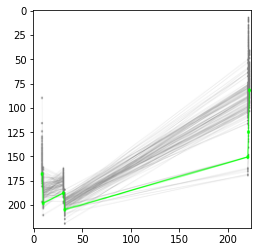

In [34]:
i=random.randrange(len(combined_img_np))
showImg(combined_img_np[i]),combined_label[i],combined_cnv_info_df.iloc[i,:],combined_cnv_info_df.iloc[i,20]

In [125]:
# tmp = list(zip(combined_img, combined_label, combined_cnv_info_index))
# random.seed(3)
# random.shuffle(tmp)
# combined_img, combined_label, combined_cnv_info_index = zip(*tmp)

## Split dataset into training(80%) and testing(20%) dataset

In [38]:
## split image arrays
train_img, test_img, train_label, test_label, train_cnv_info_df, test_cnv_info_df = train_test_split(combined_img_np,
                                                                                                    combined_label,
                                                                                                    combined_cnv_info_df,
                                                                                                    test_size=0.2,
                                                                                                    shuffle=True,
                                                                                                    random_state=3)

train_img, val_img, train_label, val_label, train_cnv_info_df, val_cnv_info_df = train_test_split(train_img,
                                                                                                  train_label,
                                                                                                  train_cnv_info_df,
                                                                                                  test_size=0.25,
                                                                                                  shuffle=True,
                                                                                                  random_state=3) # 0.25*0.8=0.2

(None,
 1,
 Unnamed: 0                                                                   711
 CHR                                                                            8
 PRED_START                                                              16110084
 PRED_END                                                                16164251
 TYPE                                                                         DEL
 SAMPLE                                                                 SP0022155
 CANOES_RT                                                                      1
 CLAMMS_RT                                                                      1
 XHMM_RT                                                                        1
 NUM_OVERLAPS_RT                                                                3
 RD_PROP_RT                                                                  0.78
 GC                                                                          0.36
 PRED

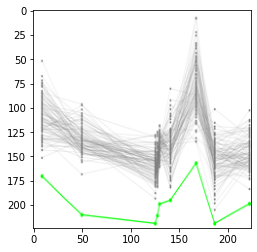

In [50]:
i=random.randrange(len(train_img))
#showImg(combined_img[i]),combined_label[i],combined_cnv_info_df.iloc[i,:],combined_cnv_info_df.iloc[i,20]
showImg(train_img[i]),train_label[i],train_cnv_info_df.iloc[i,:],train_cnv_info_df.iloc[i,20]

### Visulize training and testing dataset
- In order to check the performance in different size categories (number of windows/targets), we need to check the distribution of CNVs in training and testing set.

## Normalization

In [56]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = train_img.shape[1:]
input_shape = (nRows, nCols, nDims)

In [57]:
# Change to float datatype
train_img = train_img.astype('float32')
val_img   = val_img.astype('float32')
test_img  = test_img.astype('float32')

# Scale the data to lie between 0 to 1
train_img /= 255
val_img   /= 255
test_img  /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_label)
val_labels_one_hot   = to_categorical(val_label)
test_labels_one_hot  = to_categorical(test_label)

In [58]:
# Find the unique numbers from the train labels
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


In [59]:
#np.where(train_label==0)

1


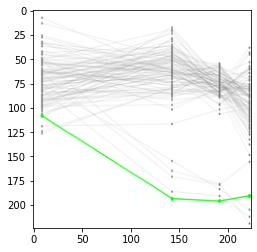

In [60]:
item = random.randint(0,len(train_label))
print(train_label[item])
showImg(train_img[item])

### Train deep nerual network model

In [61]:
model1 = createModel()
batch_size = 16
epochs = 30
#opt = keras.optimizers.Adam(learning_rate=0.01)
#model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#The learning rate. Defaults to 0.001
model1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0

In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(project_name+'_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model1.fit(train_img, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(val_img, val_labels_one_hot), callbacks=[es, mc])

## easy to exhaust the memory
# history = model1.fit(train_img, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
#                     validation_split = 0.2, callbacks=[es, mc])


Epoch 1/30
232/232 [==============================] - ETA: 0s - loss: 0.4696 - accuracy: 0.8390
Epoch 00001: val_accuracy improved from -inf to 0.84036, saving model to rare_del_entire_model.h5
232/232 [==============================] - 19s 81ms/step - loss: 0.4696 - accuracy: 0.8390 - val_loss: 0.6338 - val_accuracy: 0.8404
Epoch 2/30
231/232 [============================>.] - ETA: 0s - loss: 0.4305 - accuracy: 0.8431
Epoch 00002: val_accuracy did not improve from 0.84036
232/232 [==============================] - 19s 82ms/step - loss: 0.4301 - accuracy: 0.8433 - val_loss: 0.3842 - val_accuracy: 0.8404
Epoch 3/30
231/232 [============================>.] - ETA: 0s - loss: 0.3493 - accuracy: 0.8463
Epoch 00003: val_accuracy improved from 0.84036 to 0.84441, saving model to rare_del_entire_model.h5
232/232 [==============================] - 20s 85ms/step - loss: 0.3489 - accuracy: 0.8465 - val_loss: 0.3107 - val_accuracy: 0.8444
Epoch 4/30
231/232 [============================>.] - ETA: 

In [63]:
model1.evaluate(test_img, test_labels_one_hot)

39/39 [==============================] - 2s 45ms/step - loss: 0.2199 - accuracy: 0.9076


[0.21992255747318268, 0.9076175093650818]

Text(0.5, 1.0, 'Loss Curves')

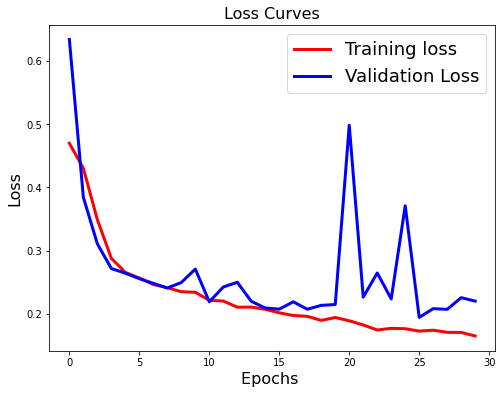

In [64]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'rare_del_entire accuracy curves')

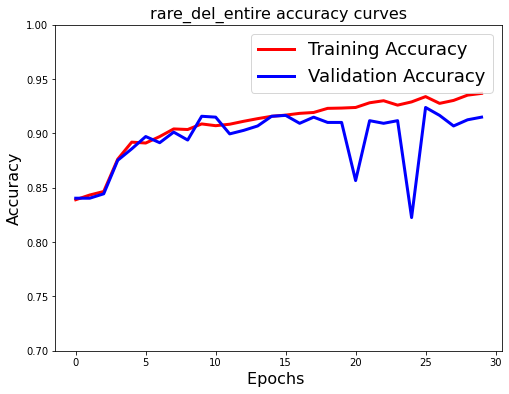

In [65]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.ylim(0.7, 1)
plt.title(project_name+' accuracy curves',fontsize=16)

### ROC curve

In [66]:
test_pred_keras = model1.predict(test_img).ravel()

In [67]:
# ravel(): Flatten the array
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels_one_hot.ravel(), test_pred_keras) 

In [68]:
auc_keras = auc(fpr_keras, tpr_keras)

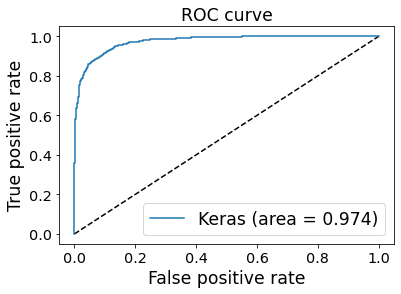

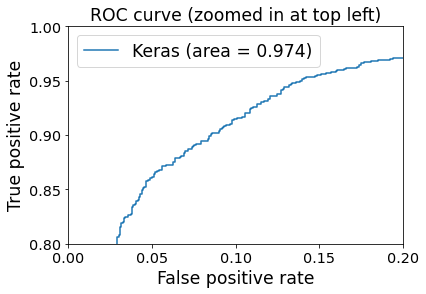

In [69]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve',fontsize="xx-large")
plt.legend(loc='best',fontsize="xx-large")
plt.tick_params(labelsize="x-large")
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.tick_params(labelsize="x-large")
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate',fontsize="xx-large")
plt.ylabel('True positive rate',fontsize="xx-large")
plt.title('ROC curve (zoomed in at top left)',fontsize="xx-large")
plt.legend(loc='best',fontsize="xx-large")
plt.show()

In [70]:
print(project_name)
time_stamp = datetime.datetime.now()
time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
print(time_str)

rare_del_entire
2021.01.26-22:36:09


## Precision

In [73]:
test_pred = model1.predict(test_img)

In [74]:
test_pred

array([[5.8860924e-02, 9.4113910e-01],
       [1.5693610e-04, 9.9984300e-01],
       [2.8481115e-02, 9.7151887e-01],
       ...,
       [5.3372347e-01, 4.6627650e-01],
       [2.7894089e-01, 7.2105914e-01],
       [2.0120753e-01, 7.9879242e-01]], dtype=float32)

1 [3.1212068e-07 9.9999964e-01] Unnamed: 0                                                                   388
CHR                                                                           15
PRED_START                                                              22810748
PRED_END                                                                23037152
TYPE                                                                         DEL
SAMPLE                                                                 SP0013001
CANOES_RT                                                                      1
CLAMMS_RT                                                                      1
XHMM_RT                                                                        1
NUM_OVERLAPS_RT                                                                3
RD_PROP_RT                                                                   0.2
GC                                                                          0

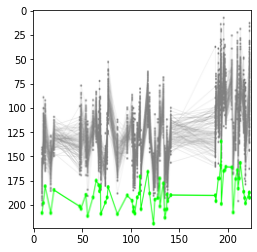

In [102]:
i=random.randrange(len(test_img))
showImg(test_img[i]), 
print(test_label[i], test_pred[i], test_cnv_info_df.iloc[i,:])

### TODO:
- Check the performance on different size categories on test data firstly and by k-fold cross validation secondly. 

## Reference:
- load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- Transfer learning and toy deomo: https://zhuanlan.zhihu.com/p/51889181
- K-fold validation: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
- ROC curve: https://medium.com/hackernoon/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a